Pre-treatment data size before filtering: (390, 18)
Pre-treatment data size after filtering: (16, 18)
Post-treatment data size before filtering: (420, 18)
Post-treatment data size after filtering: (288, 18)
Weighted Pre-Treatment Speed: 14.38 mph
Weighted Post-Treatment Speed: 13.44 mph
T-Statistic: -0.316, P-Value: 0.760


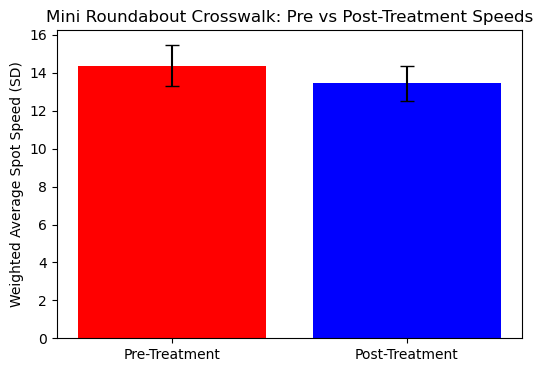

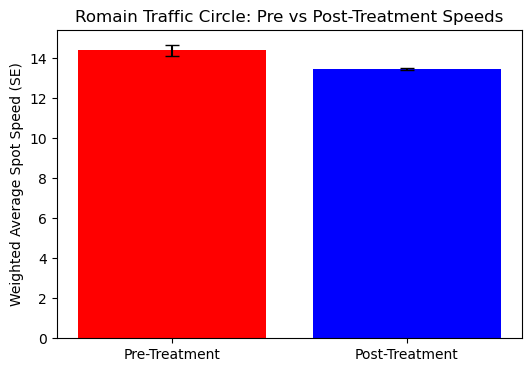

Highest value for pre-treatment'85th Speed Percentile': 22.0 mph Highest value for post-treatment'85th Speed Percentile': 21.0 mph
Row details:
Data Periods                                          Jun 01, 2019 - Jun 01, 2020
Mode of Travel                             All Vehicles - StL All Vehicles Volume
Zone ID                                                                       NaN
Zone Name                                                             Hart Street
Zone Is Pass-Through                                                          yes
Zone Direction (degrees)                                                      270
Zone is Bi-Direction                                                           no
Year-Month                                                                2019-08
Day Type                                                       2: Tuesday (Tu-Tu)
Day Part                                                    3: Mid-Day (10am-3pm)
Average Daily Spot Traffic (StL Volu

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

pre_treatment = pd.read_csv('data/Baird_Pre.csv')
post_treatment = pd.read_csv('data/Baird_Post.csv')

pre_filters = (pre_treatment['Day Type'] == '0: All Days (M-Su)') | (pre_treatment['Day Part'] == '0: All Day (12am-12am)')
post_filters = (post_treatment['Day Type'] == '0: All Days (M-Su)') | (post_treatment['Day Part'] == '0: All Day (12am-12am)')

pre_treatment = pre_treatment[~pre_filters]
post_treatment = post_treatment[~post_filters]

def filter_outliers(df, column, threshold=3):
    valid_values = df[column].dropna()
    z_scores = stats.zscore(valid_values)
    valid_indices = valid_values.index[np.abs(z_scores) < threshold]
    return df.loc[valid_indices]

pre_treatment_filtered = filter_outliers(pre_treatment, '85th Speed Percentile')
post_treatment_filtered = filter_outliers(post_treatment, '85th Speed Percentile')

print("Pre-treatment data size before filtering:", pre_treatment.shape)
print("Pre-treatment data size after filtering:", pre_treatment_filtered.shape)
print("Post-treatment data size before filtering:", post_treatment.shape)
print("Post-treatment data size after filtering:", post_treatment_filtered.shape)

pre_speeds = pre_treatment_filtered['Avg Spot Speed (mph)']
post_speeds = post_treatment_filtered['Avg Spot Speed (mph)']
pre_volume = pre_treatment_filtered['Average Daily Spot Traffic (StL Volume)']
post_volume = post_treatment_filtered['Average Daily Spot Traffic (StL Volume)']

pre_weighted_speed = (pre_speeds * pre_volume).sum() / pre_volume.sum()
post_weighted_speed = (post_speeds * post_volume).sum() / post_volume.sum()

def weighted_std(values, weights):
    mean = (values * weights).sum() / weights.sum()
    variance = (weights * (values - mean) ** 2).sum() / weights.sum()
    return variance ** 0.5

pre_weighted_std = weighted_std(pre_speeds, pre_volume)
post_weighted_std = weighted_std(post_speeds, post_volume)
pre_weighted_se = weighted_std(pre_speeds, pre_volume) / (len(pre_speeds) ** 0.5)
post_weighted_se = weighted_std(post_speeds, post_volume) / (len(post_speeds) ** 0.5)

valid_indices = pre_speeds.notna() & post_speeds.notna()
t_stat, p_value = stats.ttest_rel(pre_speeds[valid_indices], post_speeds[valid_indices])

print(f"Weighted Pre-Treatment Speed: {pre_weighted_speed:.2f} mph")
print(f"Weighted Post-Treatment Speed: {post_weighted_speed:.2f} mph")
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3f}")

bar_colors = ['red', 'blue']
plt.figure(figsize=(6, 4))
plt.bar(['Pre-Treatment', 'Post-Treatment'], 
        [pre_weighted_speed, post_weighted_speed], 
        yerr=[pre_weighted_std, post_weighted_std], capsize=5, color=bar_colors)
plt.ylabel('Weighted Average Spot Speed (SD)')
plt.title('Mini Roundabout Crosswalk: Pre vs Post-Treatment Speeds')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Pre-Treatment', 'Post-Treatment'], 
        [pre_weighted_speed, post_weighted_speed], 
        yerr=[pre_weighted_se, post_weighted_se], capsize=5, color=bar_colors)

plt.ylabel('Weighted Average Spot Speed (SE)')
plt.title('Romain Traffic Circle: Pre vs Post-Treatment Speeds')
plt.show()

max_85th_speed_row_pre = pre_treatment_filtered.loc[pre_treatment_filtered['85th Speed Percentile'].idxmax()]
max_85th_speed_row_post = post_treatment_filtered.loc[post_treatment_filtered['85th Speed Percentile'].idxmax()]

max_85th_speed_value_pre = max_85th_speed_row_pre['85th Speed Percentile']
max_85th_speed_value_post = max_85th_speed_row_post['85th Speed Percentile']

print(f"Highest value for pre-treatment'85th Speed Percentile': {max_85th_speed_value_pre} mph",
     f"Highest value for post-treatment'85th Speed Percentile': {max_85th_speed_value_post} mph")
print("Row details:")
print(max_85th_speed_row_pre,max_85th_speed_row_post )